In [1]:
#colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
torch.cuda.device_count()

1

In [4]:
ls "/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg/train/images"


0.png   12.png  15.png  18.png  20.png  23.png  26.png  4.png  7.png
10.png  13.png  16.png  19.png  21.png  24.png  2.png   5.png  8.png
11.png  14.png  17.png  1.png   22.png  25.png  3.png   6.png  9.png


In [5]:
data_path = '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg/'

In [6]:
import numpy as np
import os
from PIL import Image 
import matplotlib.pyplot as plt
input_image = Image.open(data_path + '/train/images/0.png')
label_image = Image.open(data_path +'/train/masks/0.png')

Text(0.5, 1.0, 'label')

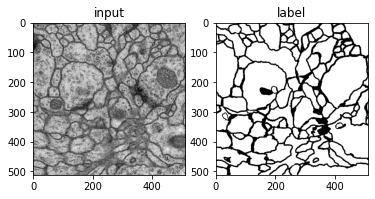

In [8]:
plt.subplot(121)
plt.imshow(input_image, cmap= 'gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_image, cmap = 'gray')
plt.title('label')

* preprocessing

In [9]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from random import randint


def add_elastic_transform(image, alpha, sigma, pad_size=30, seed=None):
    """
    Args:
        image : numpy array of image
        alpha : α is a scaling factor
        sigma :  σ is an elasticity coefficient
        random_state = random integer
        Return :
        image : elastically transformed numpy array of image
    """
    image_size = int(image.shape[0])
    image = np.pad(image, pad_size, mode="symmetric")
    if seed is None:
        seed = randint(1, 100)
        random_state = np.random.RandomState(seed)
    else:
        random_state = np.random.RandomState(seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),  sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    return cropping(map_coordinates(image, indices, order=1).reshape(shape), 512, pad_size, pad_size), seed


def flip(image, option_value):
    """
    Args:
        image : numpy array of image
        option_value = random integer between 0 to 3
    Return :
        image : numpy array of flipped image
    """
    if option_value == 0:
        # vertical
        image = np.flip(image, option_value)
    elif option_value == 1:
        # horizontal
        image = np.flip(image, option_value)
    elif option_value == 2:
        # horizontally and vertically flip
        image = np.flip(image, 0)
        image = np.flip(image, 1)
    else:
        image = image
        # no effect
    return image


def add_gaussian_noise(image, mean=0, std=1):
    """
    Args:
        image : numpy array of image
        mean : pixel mean of image
        standard deviation : pixel standard deviation of image
    Return :
        image : numpy array of image with gaussian noise added
    """
    gaus_noise = np.random.normal(mean, std, image.shape)
    image = image.astype("int16")
    noise_img = image + gaus_noise
    image = ceil_floor_image(image)
    return noise_img


def add_uniform_noise(image, low=-10, high=10):
    """
    Args:
        image : numpy array of image
        low : lower boundary of output interval
        high : upper boundary of output interval
    Return :
        image : numpy array of image with uniform noise added
    """
    uni_noise = np.random.uniform(low, high, image.shape)
    image = image.astype("int16")
    noise_img = image + uni_noise
    image = ceil_floor_image(image)
    return noise_img


def change_brightness(image, value):
    """
    Args:
        image : numpy array of image
        value : brightness
    Return :
        image : numpy array of image with brightness added
    """
    image = image.astype("int16")
    image = image + value
    image = ceil_floor_image(image)
    return image


def ceil_floor_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 with ceilling(maximum 255) and flooring(minimum 0)
    """
    image[image > 255] = 255
    image[image < 0] = 0
    image = image.astype("uint8")
    return image


def approximate_image(image):
    """
    Args:
        image : numpy array of image in datatype int16
    Return :
        image : numpy array of image in datatype uint8 only with 255 and 0
    """
    image[image > 127.5] = 255
    image[image < 127.5] = 0
    image = image.astype("uint8")
    return image


def normalization1(image, mean, std):
    """ Normalization using mean and std
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """

    image = image / 255  # values will lie between 0 and 1.
    image = (image - mean) / std

    return image


def normalization2(image, max, min):
    """Normalization to range of [min, max]
    Args :
        image : numpy array of image
        mean :
    Return :
        image : numpy array of image with values turned into standard scores
    """
    image_new = (image - np.min(image))*(max - min)/(np.max(image)-np.min(image)) + min
    return image_new


def stride_size(image_len, crop_num, crop_size):
    """return stride size
    Args :
        image_len(int) : length of one size of image (width or height)
        crop_num(int) : number of crop in certain direction
        crop_size(int) : size of crop
    Return :
        stride_size(int) : stride size
    """
    return int((image_len - crop_size)/(crop_num - 1))


def multi_cropping(image, crop_size, crop_num1, crop_num2):
    """crop the image and pad it to in_size
    Args :
        images : numpy arrays of images
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
    Return :
        cropped_imgs : numpy arrays of stacked images
    """

    img_height, img_width = image.shape[0], image.shape[1]
    assert crop_size*crop_num1 >= img_width and crop_size * \
        crop_num2 >= img_height, "Whole image cannot be sufficiently expressed"
    assert crop_num1 <= img_width - crop_size + 1 and crop_num2 <= img_height - \
        crop_size + 1, "Too many number of crops"

    cropped_imgs = []
    # int((img_height - crop_size)/(crop_num1 - 1))
    dim1_stride = stride_size(img_height, crop_num1, crop_size)
    # int((img_width - crop_size)/(crop_num2 - 1))
    dim2_stride = stride_size(img_width, crop_num2, crop_size)
    for i in range(crop_num1):
        for j in range(crop_num2):
            cropped_imgs.append(cropping(image, crop_size,
                                         dim1_stride*i, dim2_stride*j))
    return np.asarray(cropped_imgs)


# IT IS NOT USED FOR PAD AND CROP DATA OPERATION
# IF YOU WANT TO USE CROP AND PAD USE THIS FUNCTION
"""
def multi_padding(images, in_size, out_size, mode):
    '''Pad the images to in_size
    Args :
        images : numpy array of images (CxHxW)
        in_size(int) : the input_size of model (512)
        out_size(int) : the output_size of model (388)
        mode(str) : mode of padding
    Return :
        padded_imgs: numpy arrays of padded images
    '''
    pad_size = int((in_size - out_size)/2)
    padded_imgs = []
    for num in range(images.shape[0]):
        padded_imgs.append(add_padding(images[num], in_size, out_size, mode=mode))
    return np.asarray(padded_imgs)

"""


def cropping(image, crop_size, dim1, dim2):
    """crop the image and pad it to in_size
    Args :
        images : numpy array of images
        crop_size(int) : size of cropped image
        dim1(int) : vertical location of crop
        dim2(int) : horizontal location of crop
    Return :
        cropped_img: numpy array of cropped image
    """
    cropped_img = image[dim1:dim1+crop_size, dim2:dim2+crop_size]
    return cropped_img


def add_padding(image, in_size, out_size, mode):
    """Pad the image to in_size
    Args :
        images : numpy array of images
        in_size(int) : the input_size of model
        out_size(int) : the output_size of model
        mode(str) : mode of padding
    Return :
        padded_img: numpy array of padded image
    """
    pad_size = int((in_size - out_size)/2)
    padded_img = np.pad(image, pad_size, mode=mode)
    return padded_img


def division_array(crop_size, crop_num1, crop_num2, dim1, dim2):
    """Make division array
    Args :
        crop_size(int) : size of cropped image
        crop_num2 (int) : number of crop in horizontal way
        crop_num1 (int) : number of crop in vertical way
        dim1(int) : vertical size of output
        dim2(int) : horizontal size_of_output
    Return :
        div_array : numpy array of numbers of 1,2,4
    """
    div_array = np.zeros([dim1, dim2])  # make division array
    one_array = np.ones([crop_size, crop_size])  # one array to be added to div_array
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add ones to div_array at specific position
            div_array[dim1_stride*i:dim1_stride*i + crop_size,
                      dim2_stride*j:dim2_stride*j + crop_size] += one_array
    return div_array


def image_concatenate(image, crop_num1, crop_num2, dim1, dim2):
    """concatenate images
    Args :
        image : output images (should be square)
        crop_num2 (int) : number of crop in horizontal way (2)
        crop_num1 (int) : number of crop in vertical way (2)
        dim1(int) : vertical size of output (512)
        dim2(int) : horizontal size_of_output (512)
    Return :
        div_array : numpy arrays of numbers of 1,2,4
    """
    crop_size = image.shape[1]  # size of crop
    empty_array = np.zeros([dim1, dim2]).astype("float64")  # to make sure no overflow
    dim1_stride = stride_size(dim1, crop_num1, crop_size)  # vertical stride
    dim2_stride = stride_size(dim2, crop_num2, crop_size)  # horizontal stride
    index = 0
    for i in range(crop_num1):
        for j in range(crop_num2):
            # add image to empty_array at specific position
            empty_array[dim1_stride*i:dim1_stride*i + crop_size,
                        dim2_stride*j:dim2_stride*j + crop_size] += image[index]
            index += 1
    return empty_array



* Start To Training


In [10]:
import numpy as np
from PIL import Image
import glob
import torch
import torch.nn as nn
from torch.autograd import Variable
from random import randint
from torch.utils.data.dataset import Dataset
#from pre_processing import *
#from mean_std import *

* DatasetLoader with Augment
  - flip
  - Noise Determine - 0: Gaussian_noise, 1: uniform_noise
  - Brightness
  - Elastic distort - 0: distort, 1:no distort 
  - Crop the image
  - Normalize the image

In [11]:
class SEMDataTrain(Dataset):

    def __init__(self, image_path, mask_path, in_size=572, out_size=388):
        """
        Args:
            image_path (str): the path where the image is located
            mask_path (str): the path where the mask is located
            option (str): decide which dataset to import
        """
        # all file names
        self.mask_arr = glob.glob(str(mask_path) + "/*")
        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size, self.out_size = in_size, out_size
        # Calculate len
        self.data_len = len(self.mask_arr)
        # calculate mean and stdev
        print("Init SEMDataTrain", self.mask_arr)

    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index (int): index of the data
        Returns:
            Tensor: specific data on index which is converted to Tensor
        """
        """
        # GET IMAGE
        """
        #print("get SEMDataTrain", index)
        single_image_name = self.image_arr[index]
        img_as_img = Image.open(single_image_name)
        #img_as_img.show()#debug
        
        img_as_np = np.asarray(img_as_img)
        #print(img_as_np)

        # Augmentation
        # flip {0: vertical, 1: horizontal, 2: both, 3: none}
        flip_num = randint(0, 3)
        img_as_np = flip(img_as_np, flip_num)

        # Noise Determine {0: Gaussian_noise, 1: uniform_noise
        if randint(0, 1):
            # Gaussian_noise
            gaus_sd, gaus_mean = randint(0, 20), 0
            img_as_np = add_gaussian_noise(img_as_np, gaus_mean, gaus_sd)
        else:
            # uniform_noise
            l_bound, u_bound = randint(-20, 0), randint(0, 20)
            img_as_np = add_uniform_noise(img_as_np, l_bound, u_bound)

        # Brightness
        pix_add = randint(-20, 20)
        img_as_np = change_brightness(img_as_np, pix_add)

        # Elastic distort {0: distort, 1:no distort}
        sigma = randint(6, 12)
        # sigma = 4, alpha = 34
        img_as_np, seed = add_elastic_transform(img_as_np, alpha=34, sigma=sigma, pad_size=20)

        # Crop the image
        img_height, img_width = img_as_np.shape[0], img_as_np.shape[1]
        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        y_loc, x_loc = randint(0, img_height-self.out_size), randint(0, img_width-self.out_size)
        img_as_np = cropping(img_as_np, crop_size=self.in_size, dim1=y_loc, dim2=x_loc)
 
        # Normalize the image
        img_as_np = normalization2(img_as_np, max=1, min=0)
        img_as_np = np.expand_dims(img_as_np, axis=0)  # add additional dimension
        img_as_tensor = torch.from_numpy(img_as_np).float()  # Convert numpy array to tensor

        """
        # GET MASK
        """
        single_mask_name = self.mask_arr[index]
        msk_as_img = Image.open(single_mask_name)
        # msk_as_img.show()
        msk_as_np = np.asarray(msk_as_img)

        # flip the mask with respect to image
        msk_as_np = flip(msk_as_np, flip_num)

        # elastic_transform of mask with respect to image

        # sigma = 4, alpha = 34, seed = from image transformation
        msk_as_np, _ = add_elastic_transform(
            msk_as_np, alpha=34, sigma=sigma, seed=seed, pad_size=20)
        msk_as_np = approximate_image(msk_as_np)  # images only with 0 and 255

        # Crop the mask
        msk_as_np = cropping(msk_as_np, crop_size=self.out_size, dim1=y_loc, dim2=x_loc)

        # Normalize mask to only 0 and 1
        msk_as_np = msk_as_np/255
        # msk_as_np = np.expand_dims(msk_as_np, axis=0)  # add additional dimension
        msk_as_tensor = torch.from_numpy(msk_as_np).long()  # Convert numpy array to tensor

        return (img_as_tensor, msk_as_tensor)

    def __len__(self):
        """
        Returns:
            length (int): length of the data
        """
        return self.data_len

In [12]:
class SEMDataVal(Dataset):
    def __init__(self, image_path, mask_path, in_size=572, out_size=388):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks
        self.mask_arr = glob.glob(str(mask_path) + str("/*"))
        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size = in_size
        self.out_size = out_size
        self.data_len = len(self.mask_arr)
        print("init SEMDataVal", self.mask_arr)

    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index : an integer variable that calls (indext)th image in the
                    path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        """
        #print("get SEMDataVal",index)
        single_image = self.image_arr[index]
        img_as_img = Image.open(single_image)
        #img_as_img.show()# debug
        # Convert the image into numpy array
        img_as_np = np.asarray(img_as_img)

        # Make 4 cropped image (in numpy array form) using values calculated above
        # Cropped images will also have paddings to fit the model.
        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        img_as_np = multi_cropping(img_as_np,
                                   crop_size=self.in_size,
                                   crop_num1=2, crop_num2=2)

        # Empty list that will be filled in with arrays converted to tensor
        processed_list = []

        for array in img_as_np:

            # SANITY CHECK: SEE THE CROPPED & PADDED IMAGES
            #array_image = Image.fromarray(array)

            # Normalize the cropped arrays
            img_to_add = normalization2(array, max=1, min=0)
            # Convert normalized array into tensor
            processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(processed_list)
        #  return tensor of 4 cropped images
        #  top left, top right, bottom left, bottom right respectively.

        """
        # GET MASK
        """
        single_mask_name = self.mask_arr[index]
        msk_as_img = Image.open(single_mask_name)
        # msk_as_img.show()
        msk_as_np = np.asarray(msk_as_img)
        # Normalize mask to only 0 and 1
        msk_as_np = multi_cropping(msk_as_np,
                                   crop_size=self.out_size,
                                   crop_num1=2, crop_num2=2)

        msk_as_np = msk_as_np/255

        # msk_as_np = np.expand_dims(msk_as_np, axis=0)  # add additional dimension
        msk_as_tensor = torch.from_numpy(msk_as_np).long()  # Convert numpy array to tensor
        original_msk = torch.from_numpy(np.asarray(msk_as_img))
        return (img_as_tensor, msk_as_tensor, original_msk)

    def __len__(self):

        return self.data_len


In [13]:
class SEMDataTest(Dataset):

    def __init__(self, image_path, in_size=572, out_size=388):
        '''
        Args:
            image_path = path where test images are located
            mask_path = path where test masks are located
        '''
        # paths to all images and masks

        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.in_size = in_size
        self.out_size = out_size
        self.data_len = len(self.image_arr)
        print("init SEMDataTest", self.image_arr)

    def __getitem__(self, index):
        '''Get specific data corresponding to the index
        Args:
            index: an integer variable that calls(indext)th image in the
                path
        Returns:
            Tensor: 4 cropped data on index which is converted to Tensor
        '''
        #print("get SEMDataTest",index)
        single_image = self.image_arr[index]
        img_as_img = Image.open(single_image)
        #img_as_img.show() # debug
        # Convert the image into numpy array
        img_as_np = np.asarray(img_as_img)

        pad_size = int((self.in_size - self.out_size)/2)
        img_as_np = np.pad(img_as_np, pad_size, mode="symmetric")
        img_as_np = multi_cropping(img_as_np,
                                   crop_size=self.in_size,
                                   crop_num1=2, crop_num2=2)

        # Empty list that will be filled in with arrays converted to tensor
        processed_list = []

        for array in img_as_np:

            # SANITY CHECK: SEE THE PADDED AND CROPPED IMAGES
            # array_image = Image.fromarray(array)

            # Normalize the cropped arrays
            img_to_add = normalization2(array, max=1, min=0)
            # Convert normalized array into tensor
            processed_list.append(img_to_add)

        img_as_tensor = torch.Tensor(processed_list)
        #  return tensor of 4 cropped images
        #  top left, top right, bottom left, bottom right respectively.
        return img_as_tensor

    def __len__(self):

        return self.data_len

* Setting for training
 - location of data set 

In [14]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image

In [15]:
# Dataset begin
SEM_train = SEMDataTrain(data_path+'/train/images', data_path+'/train/masks')

# TO DO: finish test data loading
SEM_test = SEMDataTest(data_path+'/test/images/')
SEM_val = SEMDataVal( data_path+'/val/images', data_path+'/val/masks')
# Dataset end

Init SEMDataTrain ['/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/23.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/11.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/12.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/26.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/18.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/20.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/7.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/19.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/1.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/25.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/8.png', '/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//train/masks/2.png', '/content/drive/MyDrive/C

In [16]:
test_image = Image.open('/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/data_seg//val/masks/27.png')
#test_image

  - check about loading data set


In [17]:
len(SEM_test)

3

  - Dataloader
  

In [18]:
# Dataloader begins
SEM_train_load = torch.utils.data.DataLoader(dataset=SEM_train,  num_workers=16, batch_size=2, shuffle=True)
SEM_val_load =  torch.utils.data.DataLoader(dataset=SEM_val,  num_workers=3, batch_size=1, shuffle=True)
SEM_test_load =   torch.utils.data.DataLoader(dataset=SEM_test,  num_workers=3, batch_size=1, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


 - Model (Unet)

In [19]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torch.nn.functional import sigmoid


class Double_conv(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=0, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=0, stride=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class Conv_down(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_down, self).__init__()
        self.conv = Double_conv(in_ch, out_ch)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        pool_x = self.pool(x)
        return pool_x, x


class Conv_up(nn.Module):

    '''(conv => ReLU) * 2 => MaxPool2d'''

    def __init__(self, in_ch, out_ch):
        """
        Args:
            in_ch(int) : input channel
            out_ch(int) : output channel
        """
        super(Conv_up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = Double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1_dim = x1.size()[2]
        x2 = extract_img(x1_dim, x2)
        x1 = torch.cat((x1, x2), dim=1)
        x1 = self.conv(x1)
        return x1


def extract_img(size, in_tensor):
    """
    Args:
        size(int) : size of cut
        in_tensor(tensor) : tensor to be cut
    """
    dim1, dim2 = in_tensor.size()[2:]
    in_tensor = in_tensor[:, :, int((dim1-size)/2):int((dim1+size)/2),
                          int((dim2-size)/2):int((dim2+size)/2)]
    return in_tensor


class CleanU_Net(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CleanU_Net, self).__init__()
        self.Conv_down1 = Conv_down(in_channels, 64)
        self.Conv_down2 = Conv_down(64, 128)
        self.Conv_down3 = Conv_down(128, 256)
        self.Conv_down4 = Conv_down(256, 512)
        self.Conv_down5 = Conv_down(512, 1024)
        self.Conv_up1 = Conv_up(1024, 512)
        self.Conv_up2 = Conv_up(512, 256)
        self.Conv_up3 = Conv_up(256, 128)
        self.Conv_up4 = Conv_up(128, 64)
        self.Conv_out = nn.Conv2d(64, out_channels, 1, padding=0, stride=1)
        #self.Conv_final = nn.Conv2d(out_channels, out_channels, 1, padding=0, stride=1)

    def forward(self, x):

        x, conv1 = self.Conv_down1(x)
        #print("dConv1 => down1|", x.shape)
        x, conv2 = self.Conv_down2(x)
        #print("dConv2 => down2|", x.shape)
        x, conv3 = self.Conv_down3(x)
        #print("dConv3 => down3|", x.shape)
        x, conv4 = self.Conv_down4(x)
        #print("dConv4 => down4|", x.shape)
        _, x = self.Conv_down5(x)
        #print("dConv5|", x.shape)
        x = self.Conv_up1(x, conv4)
        #print("up1 => uConv1|", x.shape)
        x = self.Conv_up2(x, conv3)
        #print("up2 => uConv2|", x.shape)
        x = self.Conv_up3(x, conv2)
        #print("up3 => uConv3|", x.shape)
        x = self.Conv_up4(x, conv1)
        x = self.Conv_out(x)
        #x = self.Conv_final(x)

        return x


In [20]:
# Model
model = CleanU_Net(in_channels=1, out_channels=2)
#model = CleanU_Net()
model = torch.nn.DataParallel(model, device_ids=list(range(torch.cuda.device_count()))).cuda()


 - set training epoch 

In [21]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizerd
optimizer = torch.optim.RMSprop(model.module.parameters(), lr=0.001)

# Parameters
epoch_start = 0
epoch_end = 100

In [22]:
# Saving History to csv
header = ['epoch', 'train loss', 'train acc', 'val loss', 'val acc']
save_dir = "/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/history/RMS"
save_file_name = save_dir+"/history_RMS3.csv"


# Saving images and models directories
model_save_dir = save_dir+"/saved_models3"
image_save_path = save_dir+"/result_images3"

In [23]:
import numpy as np
from PIL import Image
import glob as gl
import numpy as np
from PIL import Image
import torch


def accuracy_check(mask, prediction):
    ims = [mask, prediction]
    np_ims = []
    for item in ims:
        if 'str' in str(type(item)):
            item = np.array(Image.open(item))
        elif 'PIL' in str(type(item)):
            item = np.array(item)
        elif 'torch' in str(type(item)):
            item = item.numpy()
        np_ims.append(item)

    compare = np.equal(np_ims[0], np_ims[1])
    accuracy = np.sum(compare)

    return accuracy/len(np_ims[0].flatten())


def accuracy_check_for_batch(masks, predictions, batch_size):
    total_acc = 0
    for index in range(batch_size):
        total_acc += accuracy_check(masks[index], predictions[index])
    return total_acc/batch_size


In [24]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
#from dataset import *
import torch.nn as nn
#from accuracy import accuracy_check, accuracy_check_for_batch
import csv
import os


def train_model(model, data_train, criterion, optimizer):
    """Train the model and report validation error with training error
    Args:
        model: the model to be trained
        criterion: loss function
        data_train (DataLoader): training dataset
    """
    model.train()
    for batch, (images, masks) in enumerate(data_train):
        images = Variable(images.cuda())
        masks = Variable(masks.cuda())
        outputs = model(images)
        #print (masks)
        #print("train mode",masks.shape, outputs.shape)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        # Update weights
        optimizer.step()
    # total_loss = get_loss_train(model, data_train, criterion)


def get_loss_train(model, data_train, criterion):
    """
        Calculate loss over train set
    """
    model.eval()
    total_acc = 0
    total_loss = 0
    for batch, (images, masks) in enumerate(data_train):
        with torch.no_grad():
            images = Variable(images.cuda())
            masks = Variable(masks.cuda())
            #print(masks)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = torch.argmax(outputs, dim=1).float()
            acc = accuracy_check_for_batch(masks.cpu(), preds.cpu(), images.size()[0])
            total_acc = total_acc + acc
            total_loss = total_loss + loss.cpu().item()
    return total_acc/(batch+1), total_loss/(batch + 1)


def validate_model(model, data_val, criterion, epoch, make_prediction=True, save_folder_name='prediction'):
    """
        Validation run
    """
    # calculating validation loss
    total_val_loss = 0
    total_val_acc = 0
    for batch, (images_v, masks_v, original_msk) in enumerate(data_val):
        stacked_img = torch.Tensor([]).cuda()
        for index in range(images_v.size()[1]):
            with torch.no_grad():
                
                image_v = Variable(images_v[:, index, :, :].unsqueeze(0).cuda())
                mask_v = Variable(masks_v[:, index, :, :].squeeze(1).cuda())
                #print('val-------------------',image_v)
                #print(image_v.shape, mask_v.shape)
                output_v = model(image_v)
                total_val_loss = total_val_loss + criterion(output_v, mask_v).cpu().item()
                #print('out', output_v.shape)
                output_v = torch.argmax(output_v, dim=1).float()
                stacked_img = torch.cat((stacked_img, output_v))
        if make_prediction:
            im_name = batch  # TODO: Change this to real image name so we know
            pred_msk = save_prediction_image(stacked_img, im_name, epoch, save_folder_name)
            acc_val = accuracy_check(original_msk, pred_msk)
            total_val_acc = total_val_acc + acc_val

    return total_val_acc/(batch + 1), total_val_loss/((batch + 1)*4)


def test_model(model_path, data_test, epoch, save_folder_name='prediction'):
    """
        Test run
    """
    model = torch.load(model_path)
    model = torch.nn.DataParallel(model, device_ids=list( range(torch.cuda.device_count()))).cuda()
    model.eval()
    for batch, (images_t) in enumerate(data_test):
        stacked_img = torch.Tensor([]).cuda()
        for index in range(images_t.size()[1]):
            with torch.no_grad():
                image_t = Variable(images_t[:, index, :, :].unsqueeze(0).cuda())
                # print(image_v.shape, mask_v.shape)
                output_t = model(image_t)
                output_t = torch.argmax(output_t, dim=1).float()
                stacked_img = torch.cat((stacked_img, output_t))
        im_name = batch  # TODO: Change this to real image name so we know
        _ = save_prediction_image(stacked_img, im_name, epoch, save_folder_name)
    print("Finish Prediction!")


def save_prediction_image(stacked_img, im_name, epoch, save_folder_name="result_images", save_im=True):
    """save images to save_path
    Args:
        stacked_img (numpy): stacked cropped images
        save_folder_name (str): saving folder name
    """
    div_arr = division_array(388, 2, 2, 512, 512)
    #print(stacked_img)
    img_cont = image_concatenate(stacked_img.cpu().data.numpy(), 2, 2, 512, 512)
    #print(img_cont)
    img_cont = polarize((img_cont)/div_arr)*255
    img_cont_np = img_cont.astype('uint8')
    #print(img_cont_np)
    img_cont = Image.fromarray(img_cont_np)
    img_cont.show()
    # organize images in every epoch
    desired_path = save_folder_name + '/epoch_' + str(epoch) + '/'
    # Create the path if it does not exist
    if not os.path.exists(desired_path):
        os.makedirs(desired_path)
    # Save Image!
    export_name = str(im_name) + '.png'
    img_cont.save(desired_path + export_name)
    return img_cont_np


def polarize(img):
    ''' Polarize the value to zero and one
    Args:
        img (numpy): numpy array of image to be polarized
    return:
        img (numpy): numpy array only with zero and one
    '''
    img[img >= 0.5] = 1
    img[img < 0.5] = 0
    return img



In [25]:
import os
import csv
import torch


def export_history(header, value, folder, file_name):
    """ export data to csv format
    Args:
        header (list): headers of the column
        value (list): values of correspoding column
        folder (list): folder path
        file_name: file name with path
    """
    # if folder does not exists make folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    file_existence = os.path.isfile(file_name)

    # if there is no file make file
    if file_existence == False:
        file = open(file_name, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(header)
        writer.writerow(value)
    # if there is file overwrite
    else:
        file = open(file_name, 'a', newline='')
        writer = csv.writer(file)
        writer.writerow(value)
    # close file when it is done with writing
    file.close()


def save_models(model, path, epoch):
    """Save model to given path
    Args:
        model: model to be saved
        path: path that the model would be saved
        epoch: the epoch the model finished training
    """
    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model, path+"/model_epoch_{0}.pwf".format(epoch))


In [26]:
# Train
print("Initializing Training!")
for i in range(epoch_start, epoch_end):
    # train the model
    train_model(model, SEM_train_load, criterion, optimizer)
    train_acc, train_loss = get_loss_train(model, SEM_train_load, criterion)

    #train_loss = train_loss / len(SEM_train)
    print('Epoch', str(i+1), 'Train loss:', train_loss, "Train acc", train_acc)

    # Validation every 5 epoch
    if (i+1) % 5 == 0:
        val_acc, val_loss = validate_model(model, SEM_val_load, criterion, i+1, True, image_save_path)
        print('Val loss:', val_loss, "val acc:", val_acc)
        values = [i+1, train_loss, train_acc, val_loss, val_acc]
        export_history(header, values, save_dir, save_file_name)

        if (i+1) % 5 == 0:  # save model every 1 epoch
            save_models(model, model_save_dir, i+1)

Initializing Training!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 Train loss: 103.82969720023019 Train acc 0.7688601718719159
Epoch 2 Train loss: 0.582257730620248 Train acc 0.7694373643016564
Epoch 3 Train loss: 0.5516043688569751 Train acc 0.763540417229704
Epoch 4 Train loss: 0.5451763080699104 Train acc 0.7686917351168334
Epoch 5 Train loss: 0.7446194078241076 Train acc 0.3650399313726979


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.

Val loss: 0.7445173015197118 val acc: 0.3482004801432292
Epoch 6 Train loss: 0.5508958186422076 Train acc 0.7657381610312315
Epoch 7 Train loss: 0.5416175595351628 Train acc 0.7716007090475685
Epoch 8 Train loss: 0.5402454818998065 Train acc 0.7726103806385983
Epoch 9 Train loss: 0.5470316324915204 Train acc 0.769636878824226
Epoch 10 Train loss: 0.5446986343179431 Train acc 0.768287961374368


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.513745553791523 val acc: 0.8035837809244791
Epoch 11 Train loss: 0.5452720991202763 Train acc 0.767815626755538
Epoch 12 Train loss: 0.5450758167675563 Train acc 0.7682151302704099
Epoch 13 Train loss: 0.5407895403248923 Train acc 0.7710050122982554
Epoch 14 Train loss: 0.5438680223056248 Train acc 0.769137973900369
Epoch 15 Train loss: 0.5403183783803668 Train acc 0.7710797412811442


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5143156424164772 val acc: 0.8035837809244791
Epoch 16 Train loss: 0.5486443851675306 Train acc 0.7679349558932937
Epoch 17 Train loss: 0.544322303363255 Train acc 0.7678346055448431
Epoch 18 Train loss: 0.5416476130485535 Train acc 0.7697165897393072
Epoch 19 Train loss: 0.5435684365885598 Train acc 0.7709770185840306
Epoch 20 Train loss: 0.5408125115292413 Train acc 0.769844933801983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5118342985709509 val acc: 0.8035837809244791
Epoch 21 Train loss: 0.5465312898159027 Train acc 0.7670358357499658
Epoch 22 Train loss: 0.5414658571992602 Train acc 0.7696224074973809
Epoch 23 Train loss: 0.5461087312017169 Train acc 0.7649968020740021
Epoch 24 Train loss: 0.5470172337123326 Train acc 0.7695685551827278
Epoch 25 Train loss: 0.53768076641219 Train acc 0.7719831316520657


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5116934776306152 val acc: 0.8035837809244791
Epoch 26 Train loss: 0.535996309348515 Train acc 0.773264199930158
Epoch 27 Train loss: 0.5433378219604492 Train acc 0.7696862236764194
Epoch 28 Train loss: 0.5400590854031699 Train acc 0.7709461780514097
Epoch 29 Train loss: 0.5398872814008168 Train acc 0.7696404373472208
Epoch 30 Train loss: 0.5417073496750423 Train acc 0.7681105096943656


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.509792427221934 val acc: 0.8035837809244791
Epoch 31 Train loss: 0.5366216791527612 Train acc 0.7742271362525239
Epoch 32 Train loss: 0.5367268621921539 Train acc 0.7723468127021242
Epoch 33 Train loss: 0.5427311701433999 Train acc 0.7684274554757603
Epoch 34 Train loss: 0.5413155555725098 Train acc 0.7688509197121297
Epoch 35 Train loss: 0.5398569788251605 Train acc 0.7696031914732095


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5084913397828738 val acc: 0.8035837809244791
Epoch 36 Train loss: 0.5408460540430886 Train acc 0.7688763038428253
Epoch 37 Train loss: 0.5463682413101196 Train acc 0.7645107078329259
Epoch 38 Train loss: 0.5403767377138138 Train acc 0.7715627514689585
Epoch 39 Train loss: 0.5433947358812604 Train acc 0.7665744139349862
Epoch 40 Train loss: 0.5550558226449149 Train acc 0.7676438687123271


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5122383957107862 val acc: 0.8035837809244791
Epoch 41 Train loss: 0.5552843085357121 Train acc 0.7690743949561971
Epoch 42 Train loss: 0.5424572250672749 Train acc 0.7706925739793207
Epoch 43 Train loss: 0.5394639202526638 Train acc 0.77039081122937
Epoch 44 Train loss: 0.5694450523172107 Train acc 0.7694252653234745
Epoch 45 Train loss: 0.5417484087603432 Train acc 0.7685408537418581


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5064741472403208 val acc: 0.8035837809244791
Epoch 46 Train loss: 0.5422787283148084 Train acc 0.7690369118473194
Epoch 47 Train loss: 0.5442958516733987 Train acc 0.7694456675219775
Epoch 48 Train loss: 0.5357426341090884 Train acc 0.7726756202268346
Epoch 49 Train loss: 0.5546864015715463 Train acc 0.7655301060534747
Epoch 50 Train loss: 0.545273448739733 Train acc 0.7684056298680594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5065851857264837 val acc: 0.8035837809244791
Epoch 51 Train loss: 0.5447907660688672 Train acc 0.767494647981416
Epoch 52 Train loss: 0.5352015005690711 Train acc 0.773104540865129
Epoch 53 Train loss: 0.5405128598213196 Train acc 0.7699379298695777
Epoch 54 Train loss: 0.5385747977665493 Train acc 0.7710944498428557
Epoch 55 Train loss: 0.5495711054120745 Train acc 0.761330099980262


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5105705062548319 val acc: 0.8035837809244791
Epoch 56 Train loss: 0.5430476282324109 Train acc 0.7680151412781077
Epoch 57 Train loss: 0.5508343492235456 Train acc 0.7664055027101712
Epoch 58 Train loss: 0.5485024303197861 Train acc 0.7663383652430044
Epoch 59 Train loss: 0.541670194693974 Train acc 0.7694781686986624
Epoch 60 Train loss: 0.5421137596879687 Train acc 0.768349405204743


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5043343777457873 val acc: 0.8035837809244791
Epoch 61 Train loss: 0.5450873417513711 Train acc 0.7670659645779875
Epoch 62 Train loss: 0.539938645703452 Train acc 0.7708273233833868
Epoch 63 Train loss: 250.05863189697266 Train acc 0.7718196768291757
Epoch 64 Train loss: 0.5494966123785291 Train acc 0.7676476644701882
Epoch 65 Train loss: 0.5575156680175236 Train acc 0.7699087499810213


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5370714664459229 val acc: 0.8035837809244791
Epoch 66 Train loss: 0.5438035598823002 Train acc 0.7678818152832393
Epoch 67 Train loss: 0.5364175268581935 Train acc 0.7757096169321167
Epoch 68 Train loss: 0.5405141838959285 Train acc 0.7693801906988751
Epoch 69 Train loss: 0.539315979395594 Train acc 0.7702916470552512
Epoch 70 Train loss: 0.5433454172951835 Train acc 0.7700745771525742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5075022702415785 val acc: 0.8035837809244791
Epoch 71 Train loss: 0.5600354330880302 Train acc 0.7676699645476214
Epoch 72 Train loss: 0.541355333157948 Train acc 0.7683225976648497
Epoch 73 Train loss: 0.5472928562334606 Train acc 0.7663091853544479
Epoch 74 Train loss: 0.545059757573264 Train acc 0.7662256786815057
Epoch 75 Train loss: 0.5492285106863294 Train acc 0.7670780635561696


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.507730153699716 val acc: 0.8035837809244791
Epoch 76 Train loss: 0.5439720494406564 Train acc 0.7686274444680625
Epoch 77 Train loss: 0.5442133333001818 Train acc 0.7675321310902936
Epoch 78 Train loss: 0.5416018153939929 Train acc 0.7679536974477326
Epoch 79 Train loss: 0.544011047908238 Train acc 0.7705798874178219
Epoch 80 Train loss: 0.5387391064848218 Train acc 0.7703602079316157


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5087645600239435 val acc: 0.8035837809244791
Epoch 81 Train loss: 0.546058544090816 Train acc 0.7677110061794938
Epoch 82 Train loss: 0.539066310439791 Train acc 0.7723527435737819
Epoch 83 Train loss: 0.5370699614286423 Train acc 0.7724734961207355
Epoch 84 Train loss: 0.5432465374469757 Train acc 0.770624013102956
Epoch 85 Train loss: 0.5424195740904126 Train acc 0.7678486024019556


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5062015925844511 val acc: 0.8035837809244791
Epoch 86 Train loss: 0.5399401443345206 Train acc 0.7692639456143814
Epoch 87 Train loss: 0.545706284897668 Train acc 0.7696950013664727
Epoch 88 Train loss: 0.5428984463214874 Train acc 0.7698015198214475
Epoch 89 Train loss: 0.5384467776332583 Train acc 0.7703277067549305
Epoch 90 Train loss: 0.5396998609815326 Train acc 0.7695858733279687


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5086762209733328 val acc: 0.8035837809244791
Epoch 91 Train loss: 0.5406587592193058 Train acc 0.7697818293275436
Epoch 92 Train loss: 0.542890054838998 Train acc 0.7700866761307564
Epoch 93 Train loss: 0.5462734273501805 Train acc 0.7700760005617722
Epoch 94 Train loss: 0.5483260410172599 Train acc 0.7701224985955697
Epoch 95 Train loss: 0.5408737744603839 Train acc 0.7683876000182196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5070353299379349 val acc: 0.8035837809244791
Epoch 96 Train loss: 0.5417033519063678 Train acc 0.7688914868742694
Epoch 97 Train loss: 0.5423041241509574 Train acc 0.767577917419492
Epoch 98 Train loss: 0.5429160509790693 Train acc 0.7701552370071207
Epoch 99 Train loss: 0.5405013518674033 Train acc 0.768792085465284
Epoch 100 Train loss: 0.5405365824699402 Train acc 0.7703715952051987


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

Val loss: 0.5046320110559464 val acc: 0.8035837809244791


* for prediction


In [ ]:
len(SEM_test_load)

In [ ]:
ls "/content/drive/MyDrive/Colab Notebooks/도시빅데이터응용/history/RMS/saved_models3/"

model_epoch_10.pwf  model_epoch_440.pwf  model_epoch_5.pwf


In [ ]:
print("generate test prediction")
##test_model(save_dir+"/saved_models/model_epoch_440.pwf", SEM_test_load, 440, data_path+"/result_images_test")


generate test prediction


In [ ]:
test_model(save_dir+"/saved_models3/model_epoch_10.pwf", SEM_test_load, 300, save_dir+"/result_images3/test/")